# Bombcell classification reason audit (GOOD / MUA / NOISE / NON-SOMATIC)

This notebook shows **exactly why each unit got its Bombcell label** by recomputing threshold pass/fail flags from saved run outputs.


In [159]:
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import bombcell as bc

analysis_dir = Path.cwd().resolve()
sys.path.insert(0, str(analysis_dir))
from post_analysis_setup import load_post_analysis_context

CONFIG_FILE = r'C:\Users\user\Documents\github\bombcell\py_bombcell\grant\configs\grant_recording_config_reach15_20260201_session007.json'
RUN_MODE = 'batch'   # batch | single_probe | np20_rerun
TARGET_PROBE = 'B'   # A-F


In [160]:
ctx = load_post_analysis_context(CONFIG_FILE)
mode_to_roots = {
    'batch': (ctx['DEFAULT_KS_STAGING_ROOT'], ''),
    'np20_rerun': (ctx['NP20_KS_STAGING_ROOT'], ''),
    'single_probe': (ctx['BOMBCELL_KS_SINGLEPROBE_STAGING_ROOT'], ''),
}

staging_root, save_subdir = mode_to_roots[RUN_MODE]
ks_dir = Path(staging_root) / f'kilosort4_{TARGET_PROBE}'
save_path = ks_dir / 'bombcell' / save_subdir

print('ks_dir:', ks_dir)
print('save_path:', save_path)


ks_dir: H:\Grant\Neuropixels\Kilosort_Recordings\Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00\bombcell\bombcell_DEFAULT\kilosort4_B
save_path: H:\Grant\Neuropixels\Kilosort_Recordings\Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00\bombcell\bombcell_DEFAULT\kilosort4_B\bombcell


In [161]:
param, quality_metrics, _ = bc.load_bc_results(str(save_path))
unit_type, unit_type_string = bc.qm.get_quality_unit_type(param, quality_metrics)
qm_df = pd.DataFrame(quality_metrics).copy()
qm_df['bombcell_label'] = unit_type_string
qm_df['unit_index'] = np.arange(len(qm_df))

if 'cluster_id' not in qm_df.columns:
    qm_df['cluster_id'] = qm_df['unit_index']

print('Loaded units:', len(qm_df))
print(qm_df['bombcell_label'].value_counts(dropna=False))


Loaded units: 1316
bombcell_label
MUA         779
NON-SOMA    286
NOISE       247
GOOD          4
Name: count, dtype: int64


## Build explicit threshold-fail flags for each class block


In [162]:
def col(name):
    if name in qm_df.columns:
        return qm_df[name]
    return pd.Series(np.nan, index=qm_df.index)

noise_fail = {
    'nPeaks>maxNPeaks': col('nPeaks') > param['maxNPeaks'],
    'nTroughs>maxNTroughs': col('nTroughs') > param['maxNTroughs'],
    'wvDuration<minWvDuration': col('waveformDuration_peakTrough') < param['minWvDuration'],
    'wvDuration>maxWvDuration': col('waveformDuration_peakTrough') > param['maxWvDuration'],
    'baselineFlatness>maxWvBaselineFraction': col('waveformBaselineFlatness') > param['maxWvBaselineFraction'],
    'scndPeakToTroughRatio>maxScndPeakToTroughRatio_noise': col('scndPeakToTroughRatio') > param['maxScndPeakToTroughRatio_noise'],
}
if bool(param.get('computeSpatialDecay', False)):
    if bool(param.get('spDecayLinFit', False)):
        noise_fail['spatialDecaySlope<minSpatialDecaySlope'] = col('spatialDecaySlope') < param['minSpatialDecaySlope']
    else:
        noise_fail['spatialDecaySlope<minSpatialDecaySlopeExp'] = col('spatialDecaySlope') < param['minSpatialDecaySlopeExp']
        noise_fail['spatialDecaySlope>maxSpatialDecaySlopeExp'] = col('spatialDecaySlope') > param['maxSpatialDecaySlopeExp']

mua_fail = {
    'percentageSpikesMissing_gaussian>maxPercSpikesMissing': col('percentageSpikesMissing_gaussian') > param['maxPercSpikesMissing'],
    'nSpikes<minNumSpikes': col('nSpikes') < param['minNumSpikes'],
    'fractionRPVs_estimatedTauR>maxRPVviolations': col('fractionRPVs_estimatedTauR') > param['maxRPVviolations'],
    'presenceRatio<minPresenceRatio': col('presenceRatio') < param['minPresenceRatio'],
}
if bool(param.get('extractRaw', False)):
    mua_fail['rawAmplitude<minAmplitude'] = col('rawAmplitude') < param['minAmplitude']
    mua_fail['signalToNoiseRatio<minSNR'] = col('signalToNoiseRatio') < param['minSNR']
if bool(param.get('computeDrift', False)):
    mua_fail['maxDriftEstimate>maxDrift'] = col('maxDriftEstimate') > param['maxDrift']
if bool(param.get('computeDistanceMetrics', False)):
    mua_fail['isolationDistance<isoDmin'] = col('isolationDistance') < param['isoDmin']
    mua_fail['Lratio>lratioMax'] = col('Lratio') > param['lratioMax']

non_soma_fail = {
    'troughToPeak2Ratio<minTroughToPeak2Ratio_nonSomatic': col('troughToPeak2Ratio') < param['minTroughToPeak2Ratio_nonSomatic'],
    'mainPeak_before_width<minWidthFirstPeak_nonSomatic': col('mainPeak_before_width') < param['minWidthFirstPeak_nonSomatic'],
    'mainTrough_width<minWidthMainTrough_nonSomatic': col('mainTrough_width') < param['minWidthMainTrough_nonSomatic'],
    'peak1ToPeak2Ratio>maxPeak1ToPeak2Ratio_nonSomatic': col('peak1ToPeak2Ratio') > param['maxPeak1ToPeak2Ratio_nonSomatic'],
    'mainPeakToTroughRatio>maxMainPeakToTroughRatio_nonSomatic': col('mainPeakToTroughRatio') > param['maxMainPeakToTroughRatio_nonSomatic'],
}

for prefix, flag_dict in [('noise_', noise_fail), ('mua_', mua_fail), ('nonsoma_', non_soma_fail)]:
    for k, v in flag_dict.items():
        qm_df[prefix + k] = v.fillna(False).astype(bool)


In [163]:
noise_fail_np = {k: np.asarray(v, dtype=bool) for k, v in noise_fail.items()}
mua_fail_np = {k: np.asarray(v, dtype=bool) for k, v in mua_fail.items()}
nonsoma_fail_np = {k: np.asarray(v, dtype=bool) for k, v in non_soma_fail.items()}
labels_np = qm_df['bombcell_label'].astype(str).to_numpy()

def reasons_for_unit(i: int) -> str:
    label = labels_np[i]
    reasons = []

    noise_hits = [k for k, v in noise_fail_np.items() if bool(v[i])]
    mua_hits = [k for k, v in mua_fail_np.items() if bool(v[i])]
    nonsoma_hits = [k for k, v in nonsoma_fail_np.items() if bool(v[i])]

    if label == 'NOISE':
        reasons.extend([f'NOISE: {r}' for r in noise_hits] or ['NOISE: classified by noise mask'])
    elif label in ('MUA', 'NON-SOMA MUA'):
        reasons.extend([f'MUA: {r}' for r in mua_hits] or ['MUA: classified by MUA mask'])
    elif label in ('NON-SOMA', 'NON-SOMA GOOD'):
        # non-soma can be reassigned from GOOD (or MUA when split)
        reasons.extend([f'NON-SOMA: {r}' for r in nonsoma_hits] or ['NON-SOMA: non-somatic waveform rule'])

    if label == 'GOOD':
        reasons.append('GOOD: passed NOISE and MUA thresholds, and not non-somatic')

    return ' | '.join(reasons)

qm_df['classification_reason'] = [reasons_for_unit(i) for i in range(len(qm_df))]


In [164]:
import matplotlib.pyplot as plt

def _series(name):
    return qm_df[name] if name in qm_df.columns else pd.Series(np.nan, index=qm_df.index)

def _param(name, default=np.nan):
    return param[name] if isinstance(param, dict) and name in param else default

labels = qm_df['bombcell_label'].astype(str)


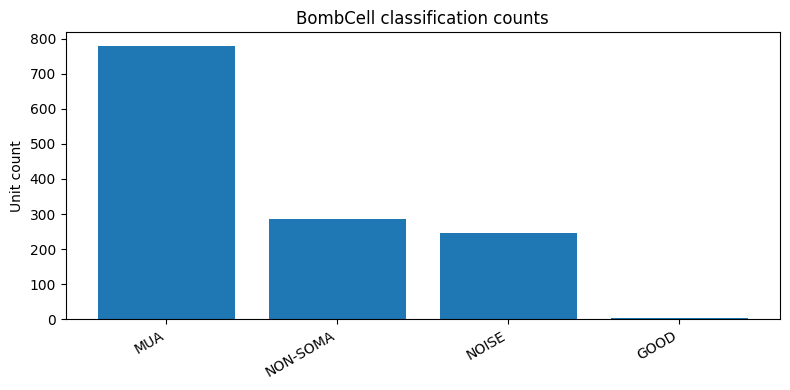

In [165]:
# 1) Class counts
counts = labels.value_counts().sort_values(ascending=False)

plt.figure(figsize=(8, 4))
plt.bar(counts.index, counts.values)
plt.ylabel("Unit count")
plt.title("BombCell classification counts")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


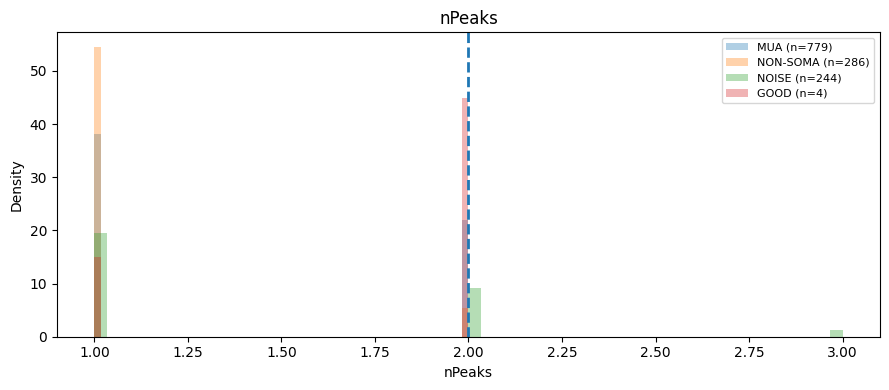

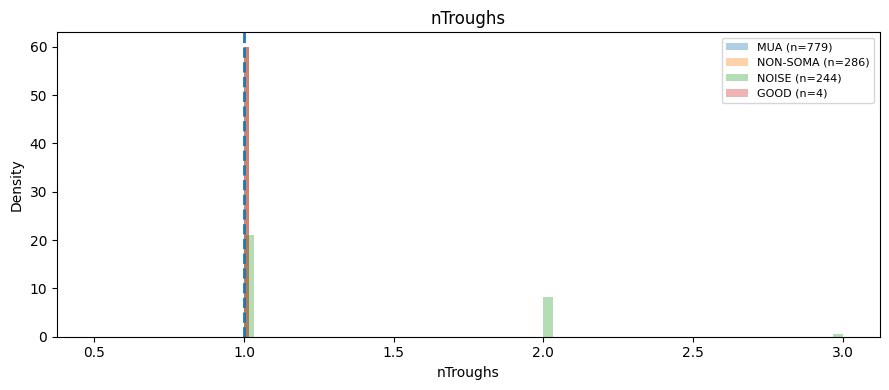

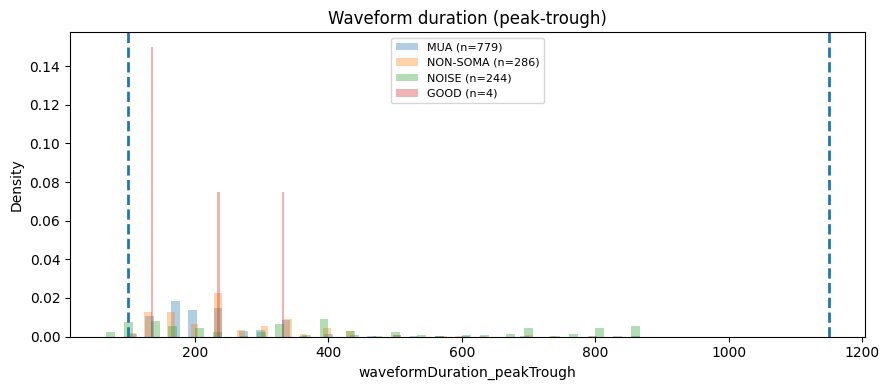

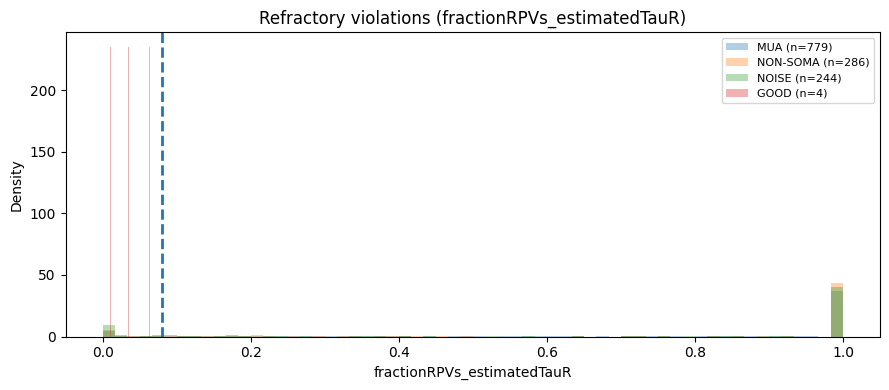

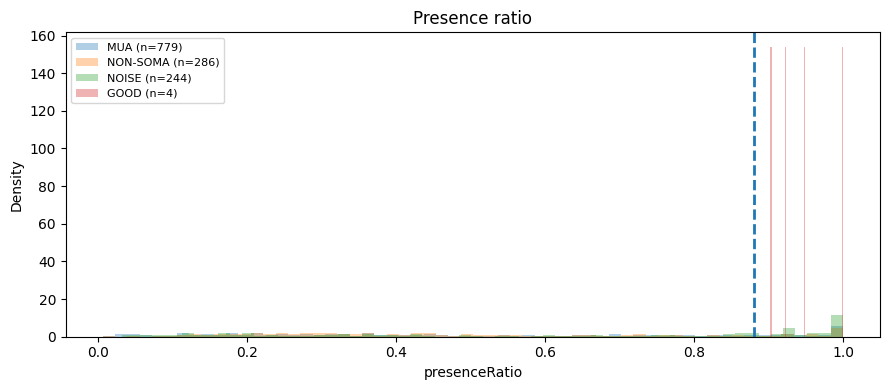

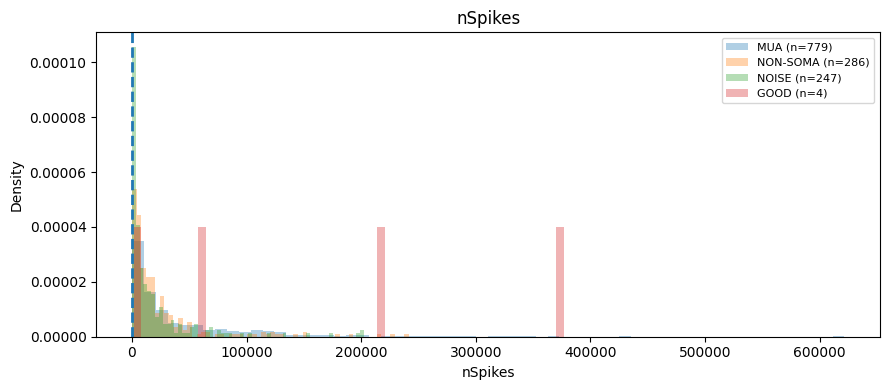

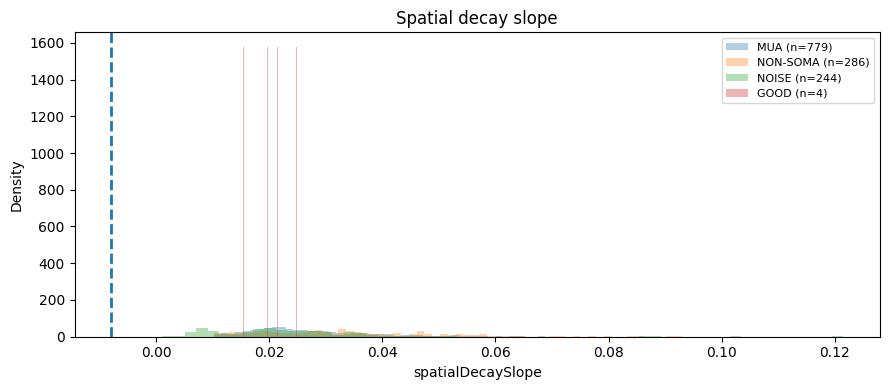

In [166]:
# 2) Metric distributions with thresholds (when available)
metric_specs = [
    # (column, lower_param_key, upper_param_key, human_title)
    ("nPeaks", None, "maxNPeaks", "nPeaks"),
    ("nTroughs", None, "maxNTroughs", "nTroughs"),
    ("waveformDuration_peakTrough", "minWvDuration", "maxWvDuration", "Waveform duration (peak-trough)"),
    ("fractionRPVs_estimatedTauR", None, "maxRPVviolations", "Refractory violations (fractionRPVs_estimatedTauR)"),
    ("presenceRatio", "minPresenceRatio", None, "Presence ratio"),
    ("nSpikes", "minNumSpikes", None, "nSpikes"),
    ("spatialDecaySlope", "minSpatialDecaySlope", None, "Spatial decay slope"),
    ("spatialDecayFitR2", "minSpatialDecayFitR2", None, "Spatial decay fit R2"),
]

metric_specs = [m for m in metric_specs if m[0] in qm_df.columns]

def plot_metric(col, lo_key, hi_key, title):
    x = _series(col).astype(float)
    lo = _param(lo_key) if lo_key else None
    hi = _param(hi_key) if hi_key else None

    # robust finite mask
    m = np.isfinite(x.to_numpy())
    if m.sum() == 0:
        return

    plt.figure(figsize=(9, 4))
    for lab in counts.index:
        sel = (labels == lab).to_numpy() & m
        if sel.sum() == 0:
            continue
        plt.hist(x[sel], bins=60, alpha=0.35, density=True, label=f"{lab} (n={sel.sum()})")

    if lo is not None and np.isfinite(lo):
        plt.axvline(lo, linestyle="--", linewidth=2)
    if hi is not None and np.isfinite(hi):
        plt.axvline(hi, linestyle="--", linewidth=2)

    plt.title(title)
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

for col, lo_key, hi_key, title in metric_specs:
    plot_metric(col, lo_key, hi_key, title)


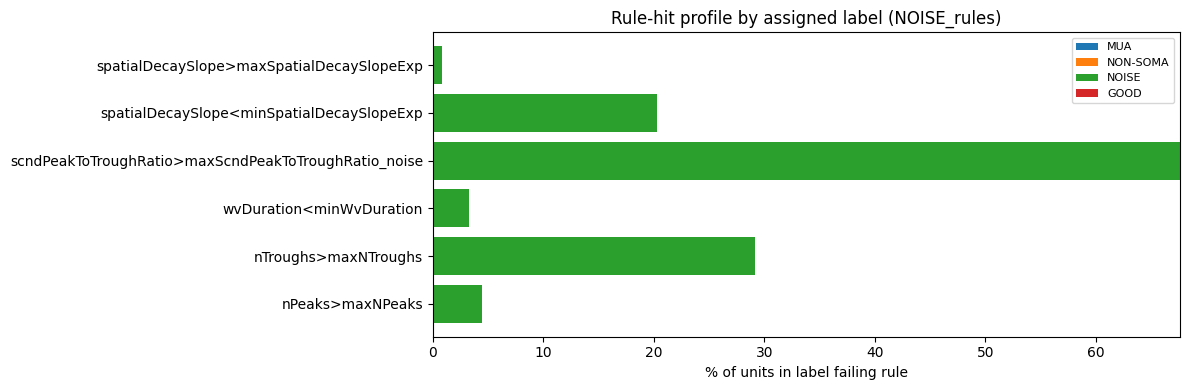

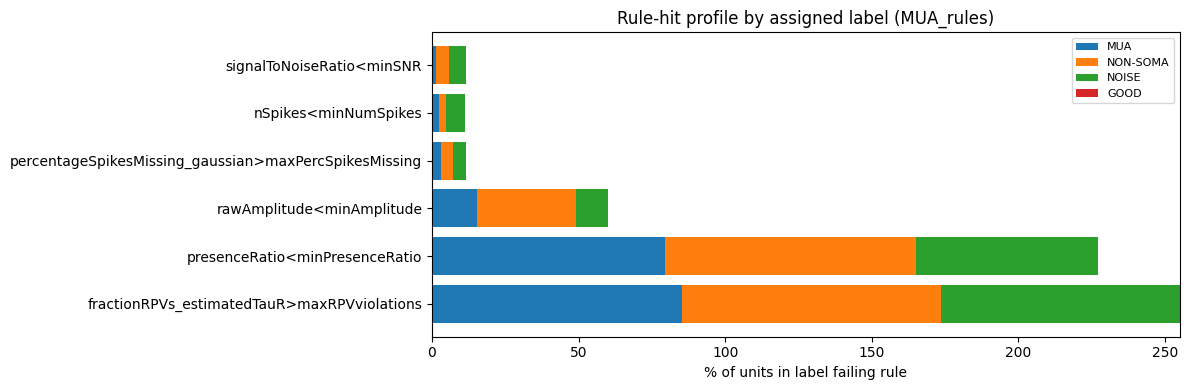

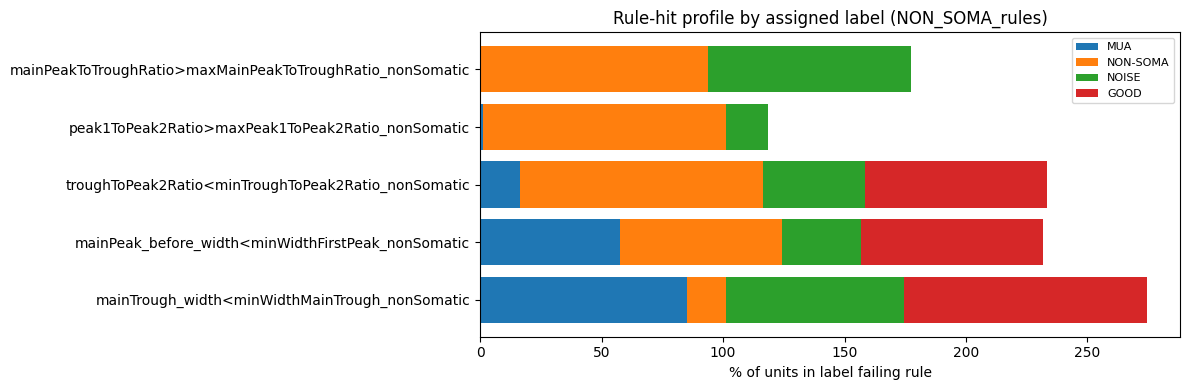

In [167]:
# 3) Which criteria drive each class? (frequency of failing each rule within each label)
# Uses the already-built fail dictionaries in this notebook: noise_fail, mua_fail, non_soma_fail
def fail_df(fail_dict):
    return pd.DataFrame({k: pd.Series(v, index=qm_df.index).astype(bool) for k, v in fail_dict.items()})

fail_tables = {
    "NOISE_rules": fail_df(noise_fail) if "noise_fail" in globals() else None,
    "MUA_rules": fail_df(mua_fail) if "mua_fail" in globals() else None,
    "NON_SOMA_rules": fail_df(non_soma_fail) if "non_soma_fail" in globals() else None,
}
fail_tables = {k: v for k, v in fail_tables.items() if v is not None}

for table_name, fdf in fail_tables.items():
    # proportion failing each rule, stratified by assigned label
    out = (fdf.groupby(labels).mean().T * 100.0)
    out = out.loc[:, [c for c in counts.index if c in out.columns]]
    # keep only rules that ever fire
    out = out.loc[out.max(axis=1) > 0].sort_values(by=out.columns[0], ascending=False)

    if out.shape[0] == 0:
        continue

    plt.figure(figsize=(12, max(4, 0.35 * out.shape[0])))
    y = np.arange(out.shape[0])
    left = np.zeros(out.shape[0], dtype=float)
    for lab in out.columns:
        vals = out[lab].to_numpy()
        plt.barh(y, vals, left=left, label=lab)
        left += vals

    plt.yticks(y, out.index)
    plt.xlabel("% of units in label failing rule")
    plt.title(f"Rule-hit profile by assigned label ({table_name})")
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_31360\894274354.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


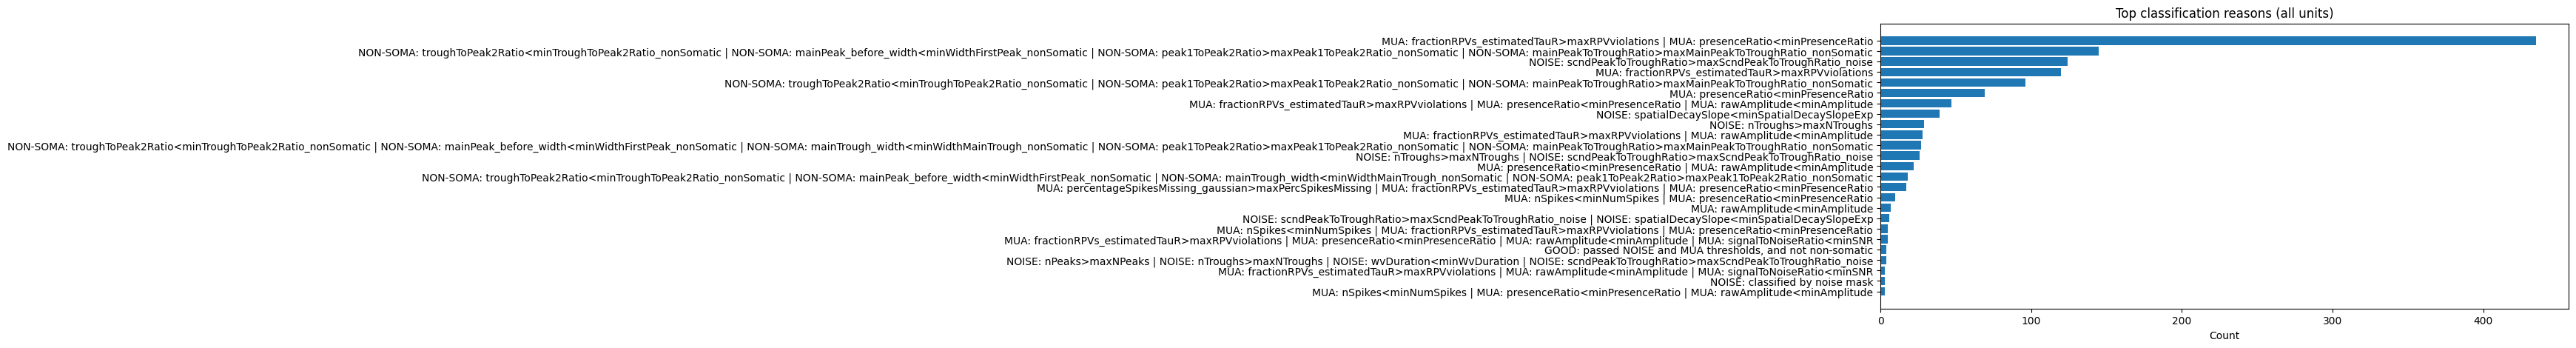

C:\Users\user\AppData\Local\Temp\ipykernel_31360\894274354.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


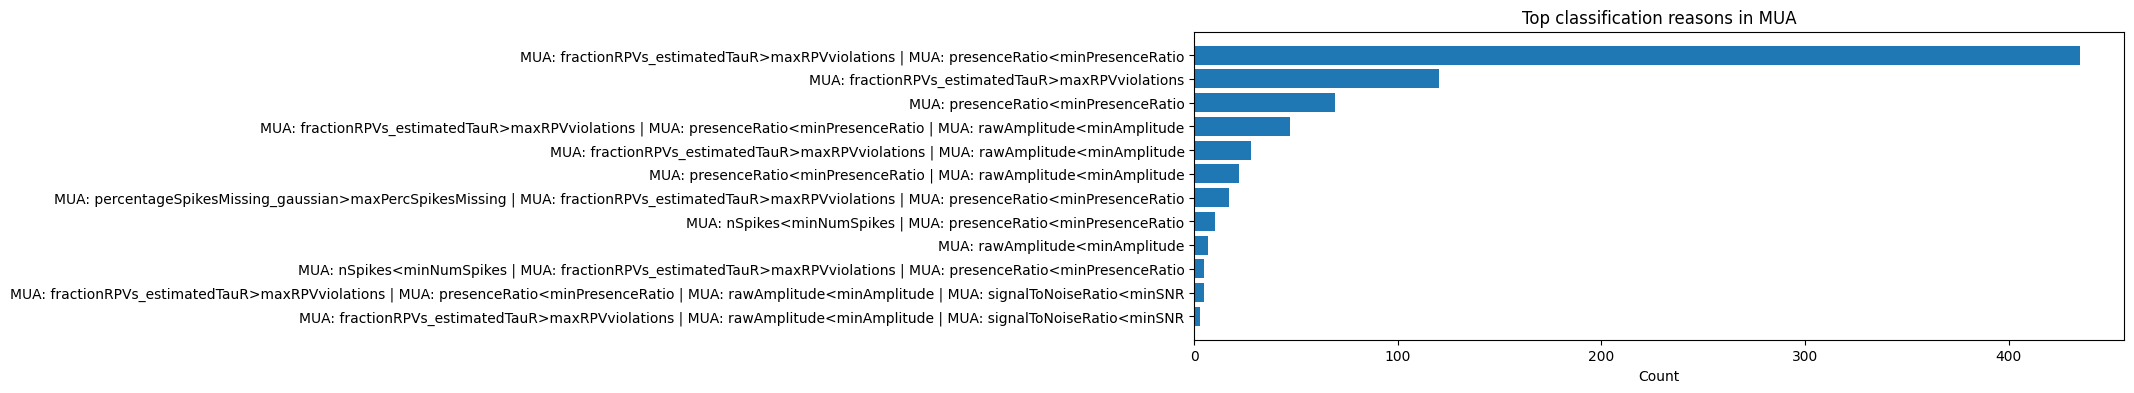

C:\Users\user\AppData\Local\Temp\ipykernel_31360\894274354.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


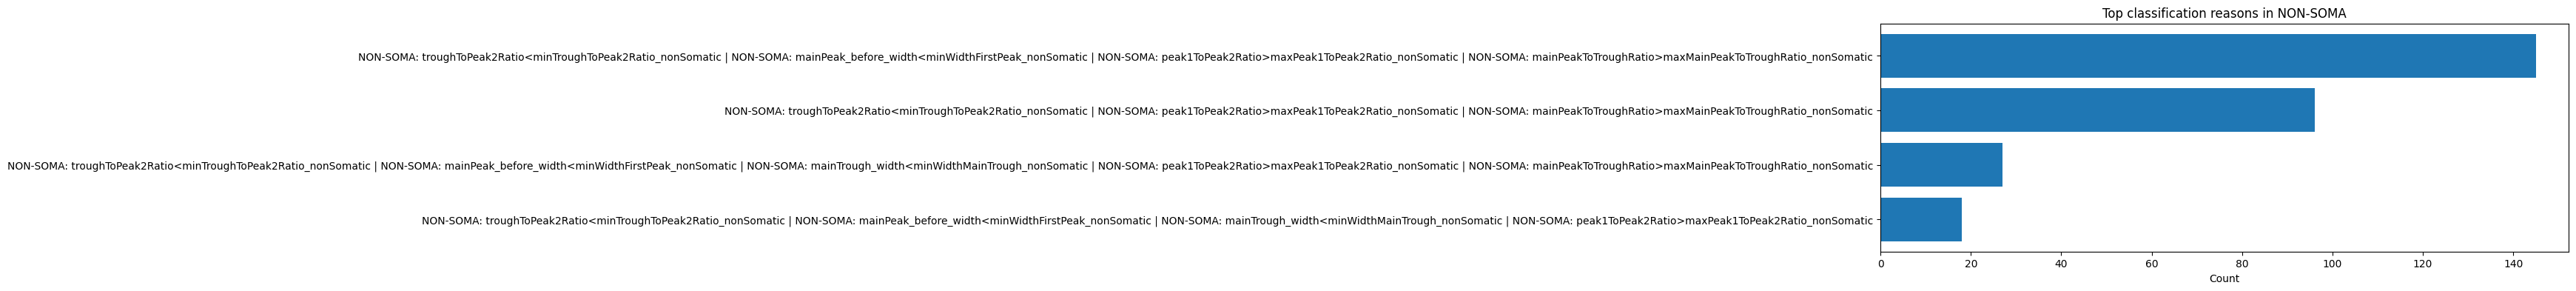

C:\Users\user\AppData\Local\Temp\ipykernel_31360\894274354.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


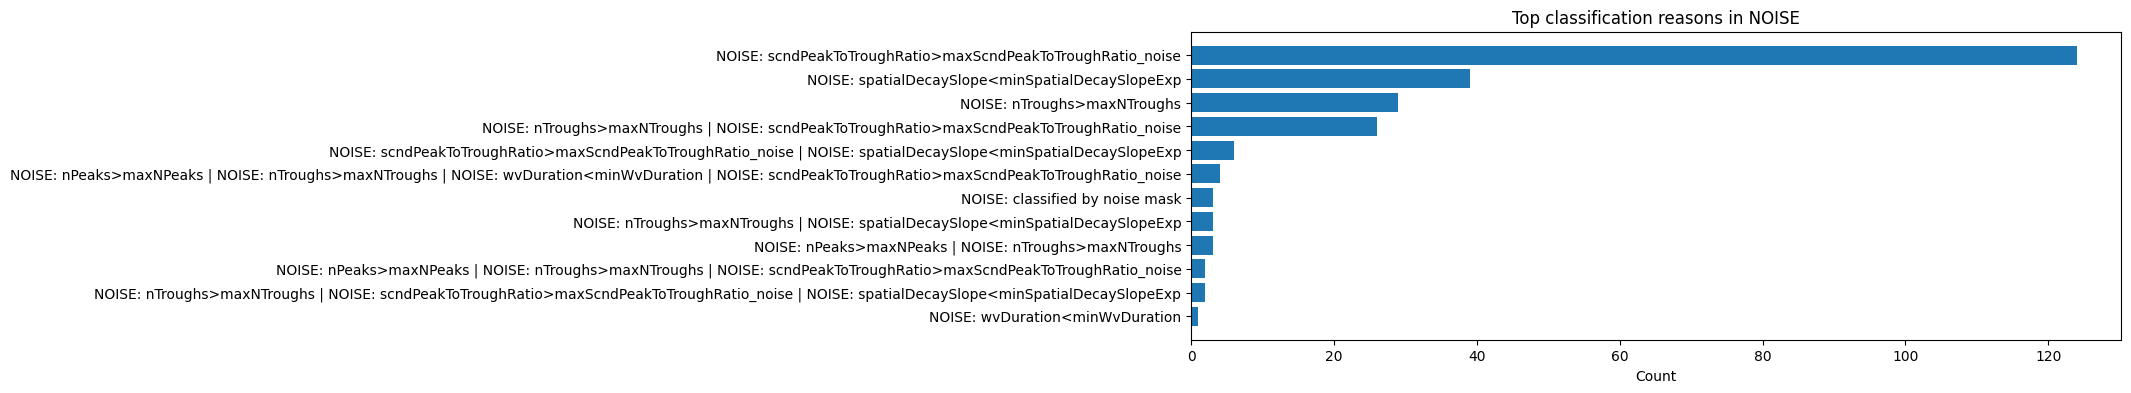

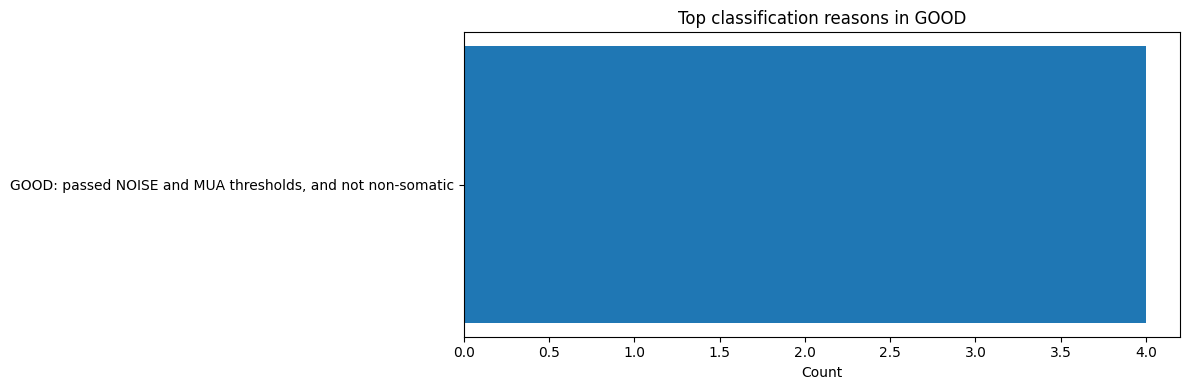

In [168]:
# 4) Reason strings -> top reasons overall + by class (requires classification_reason column)
if "classification_reason" in qm_df.columns:
    reasons = qm_df["classification_reason"].fillna("").astype(str)
    # explode on ';' used in this notebook
    reason_list = reasons.str.split(";").explode().str.strip()
    reason_list = reason_list[reason_list != ""]

    top = reason_list.value_counts().head(25)

    plt.figure(figsize=(12, 5))
    plt.barh(top.index[::-1], top.values[::-1])
    plt.xlabel("Count")
    plt.title("Top classification reasons (all units)")
    plt.tight_layout()
    plt.show()

    # by label: show the most common reasons in each label (top 12 per label)
    for lab in counts.index:
        idx = (labels == lab)
        rlab = qm_df.loc[idx, "classification_reason"].fillna("").astype(str).str.split(";").explode().str.strip()
        rlab = rlab[rlab != ""]
        top_lab = rlab.value_counts().head(12)
        if top_lab.shape[0] == 0:
            continue

        plt.figure(figsize=(12, 4))
        plt.barh(top_lab.index[::-1], top_lab.values[::-1])
        plt.xlabel("Count")
        plt.title(f"Top classification reasons in {lab}")
        plt.tight_layout()
        plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_31360\3945120576.py:27: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


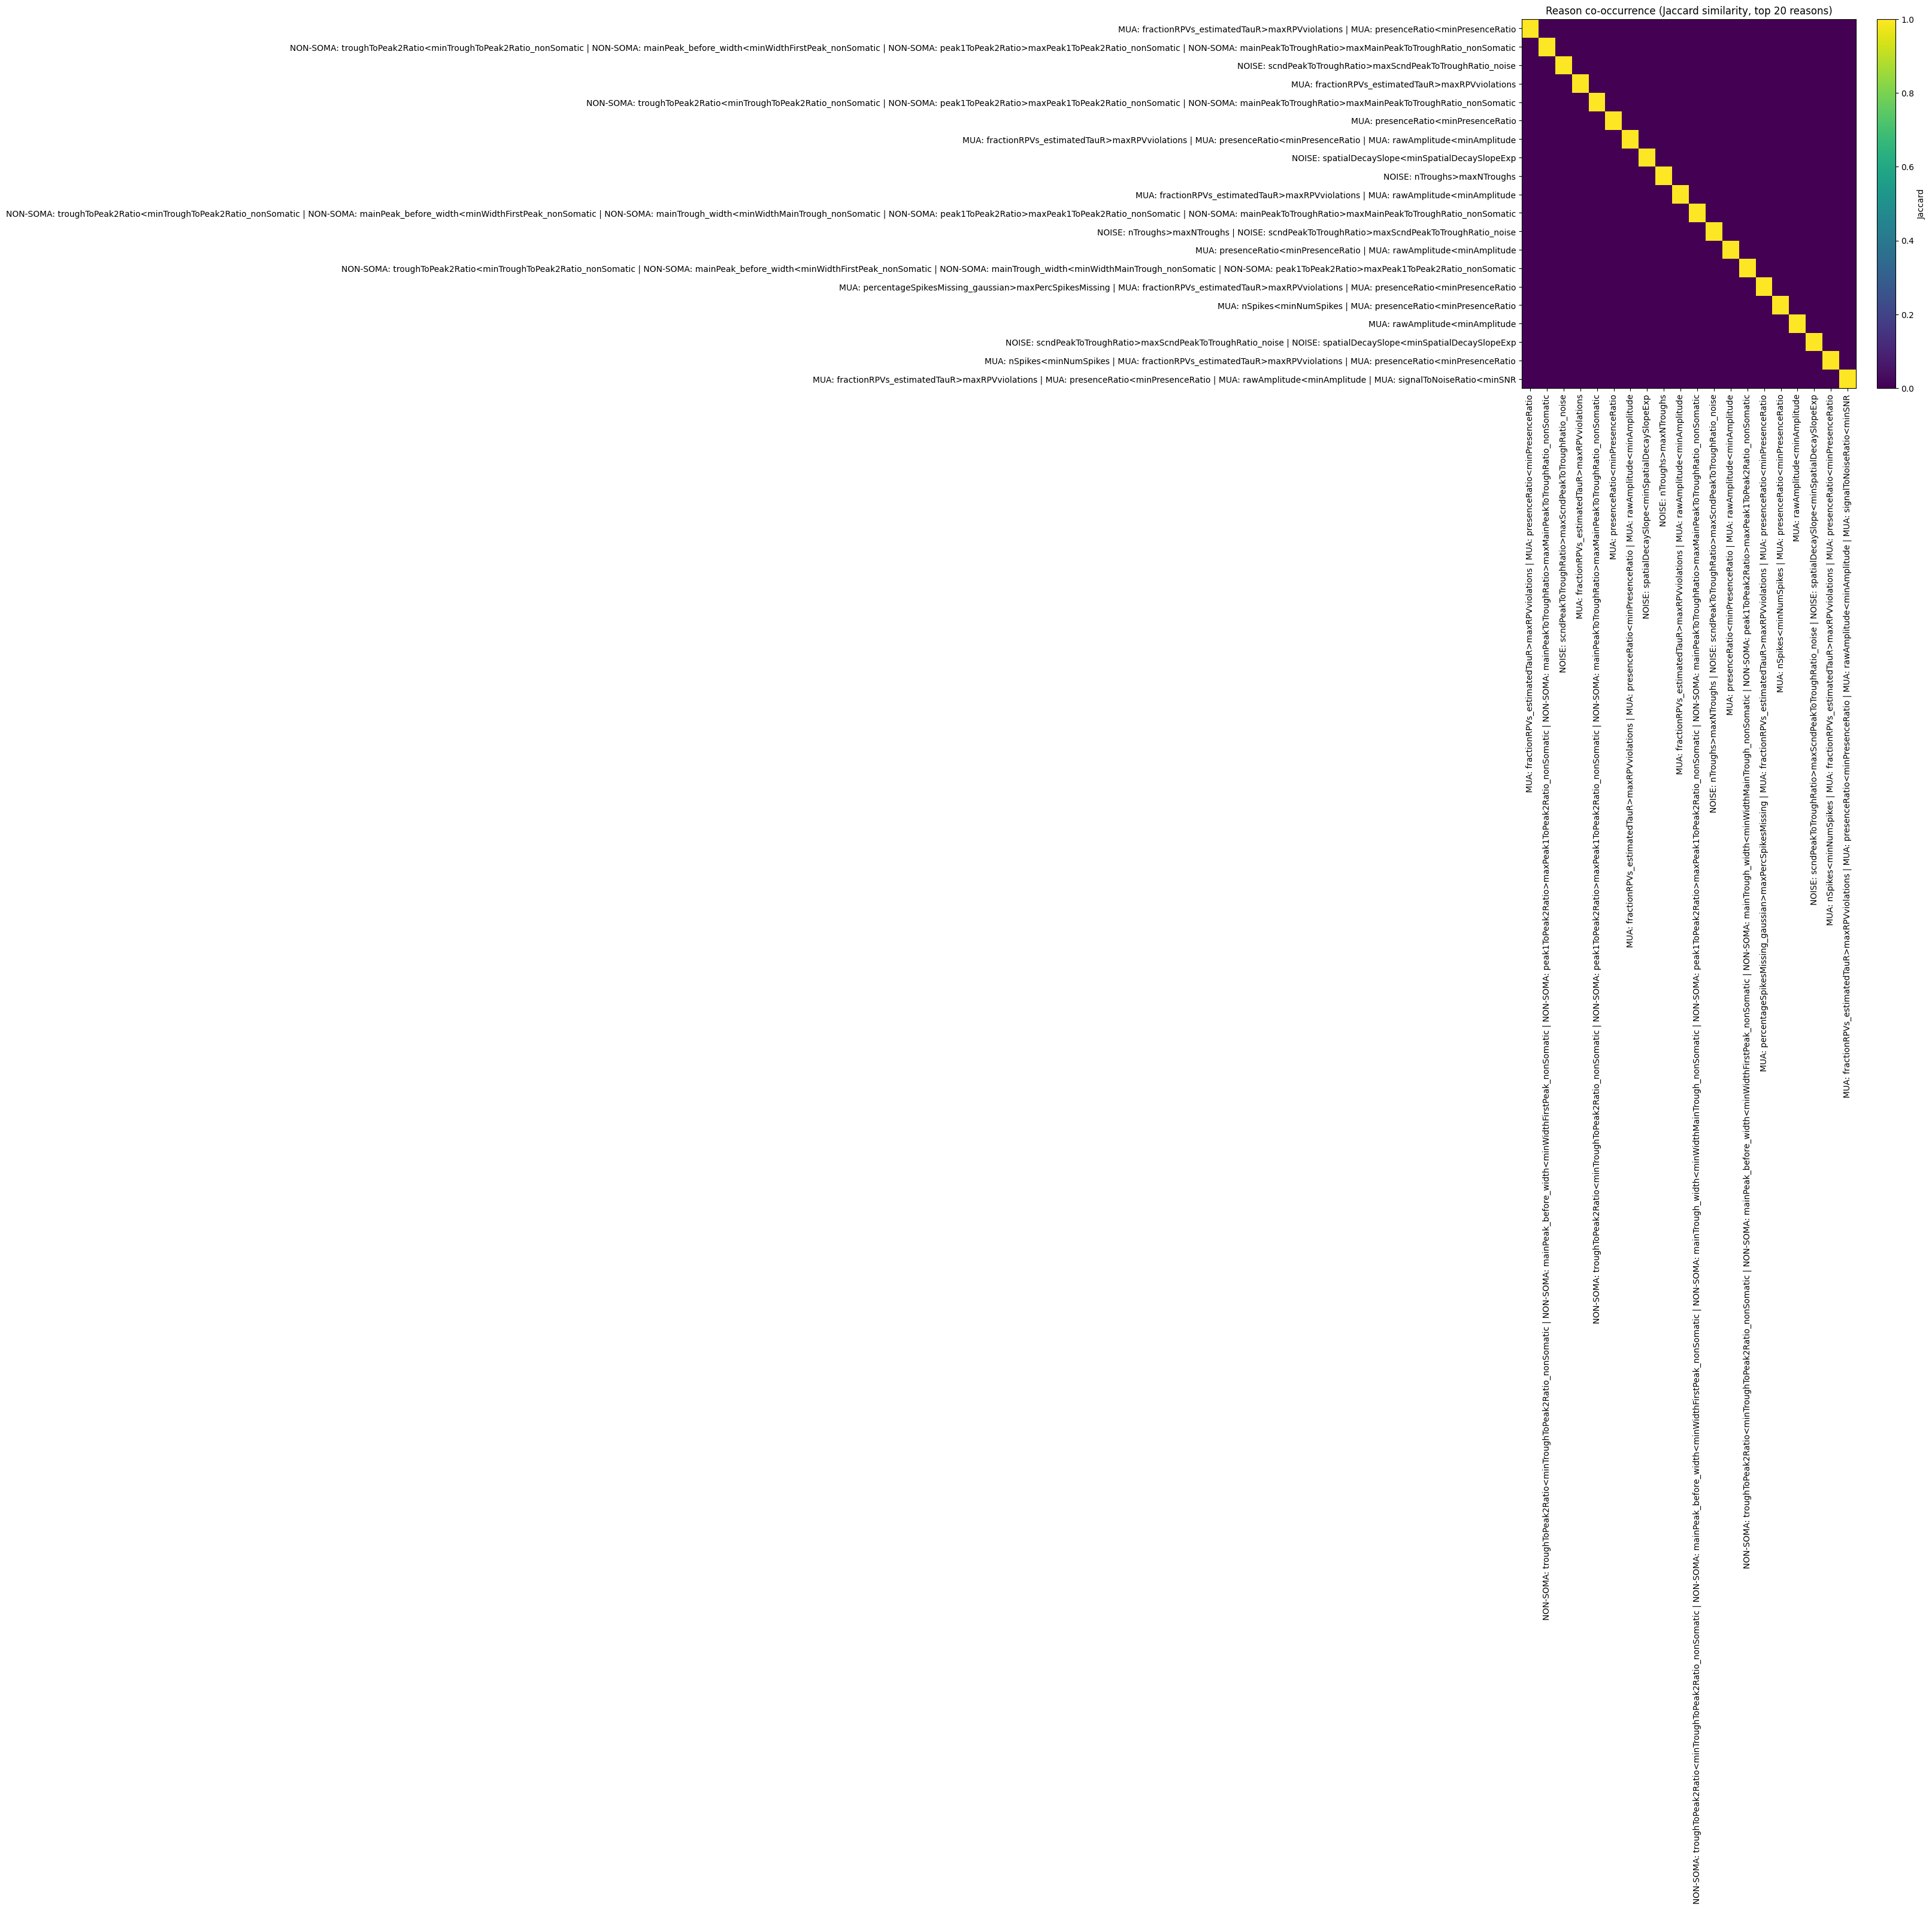

In [169]:
# 5) Co-occurrence of reasons (heatmap of Jaccard similarity between top reasons)
if "classification_reason" in qm_df.columns:
    reasons = qm_df["classification_reason"].fillna("").astype(str).str.split(";").apply(lambda xs: [x.strip() for x in xs if x.strip()])
    all_reasons = pd.Series([r for rs in reasons for r in rs])
    top_reasons = all_reasons.value_counts().head(20).index.tolist()

    if len(top_reasons) >= 2:
        M = pd.DataFrame(False, index=qm_df.index, columns=top_reasons)
        for r in top_reasons:
            M[r] = reasons.apply(lambda xs, r=r: r in xs)

        # Jaccard similarity
        A = M.to_numpy(dtype=bool)
        sims = np.zeros((len(top_reasons), len(top_reasons)), dtype=float)
        for i in range(len(top_reasons)):
            for j in range(len(top_reasons)):
                inter = np.logical_and(A[:, i], A[:, j]).sum()
                union = np.logical_or(A[:, i], A[:, j]).sum()
                sims[i, j] = inter / union if union else 0.0

        plt.figure(figsize=(9, 8))
        plt.imshow(sims, aspect="auto")
        plt.xticks(range(len(top_reasons)), top_reasons, rotation=90)
        plt.yticks(range(len(top_reasons)), top_reasons)
        plt.title("Reason co-occurrence (Jaccard similarity, top 20 reasons)")
        plt.colorbar(label="Jaccard")
        plt.tight_layout()
        plt.show()


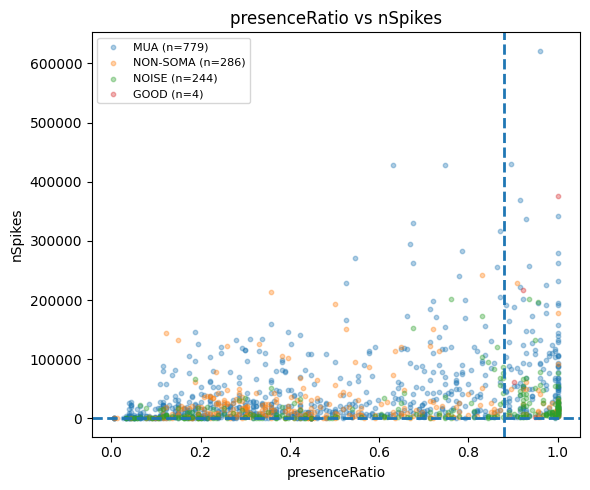

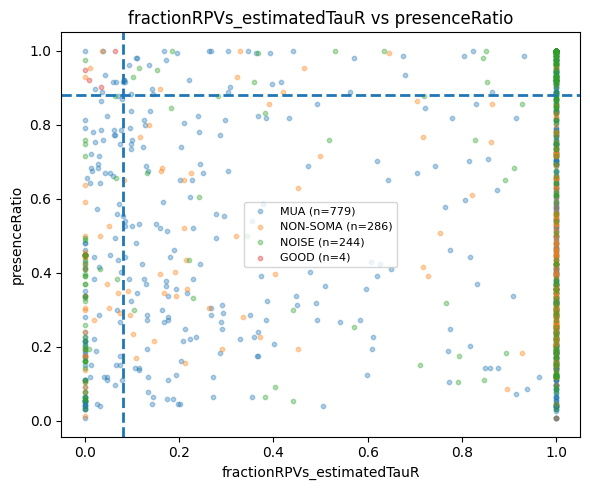

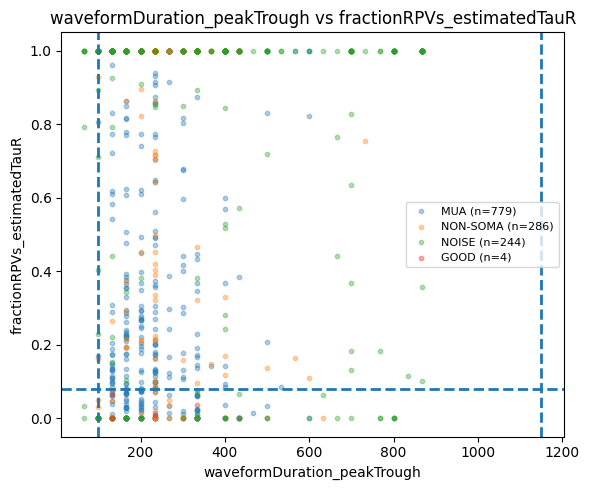

In [170]:
# 6) Pairwise scatter plots for common separations (colored by label)
# (Avoid seaborn; keep simple and robust)
pairs = [
    ("presenceRatio", "nSpikes"),
    ("fractionRPVs_estimatedTauR", "presenceRatio"),
    ("waveformDuration_peakTrough", "fractionRPVs_estimatedTauR"),
    ("spatialDecayFitR2", "spatialDecaySlope"),
]
pairs = [(a, b) for a, b in pairs if a in qm_df.columns and b in qm_df.columns]

for a, b in pairs:
    xa = _series(a).astype(float)
    xb = _series(b).astype(float)
    m = np.isfinite(xa.to_numpy()) & np.isfinite(xb.to_numpy())

    plt.figure(figsize=(6, 5))
    for lab in counts.index:
        sel = (labels == lab).to_numpy() & m
        if sel.sum() == 0:
            continue
        plt.scatter(xa[sel], xb[sel], s=10, alpha=0.35, label=f"{lab} (n={sel.sum()})")

    # draw threshold lines if known
    # x thresholds
    for key, axis in [("minPresenceRatio", "x"), ("minNumSpikes", "y"), ("maxRPVviolations", "x"), ("minWvDuration", "x"), ("maxWvDuration", "x")]:
        pass

    # generic thresholds for selected columns
    thresh_map = {
        "presenceRatio": ("minPresenceRatio", None),
        "nSpikes": ("minNumSpikes", None),
        "fractionRPVs_estimatedTauR": (None, "maxRPVviolations"),
        "waveformDuration_peakTrough": ("minWvDuration", "maxWvDuration"),
        "spatialDecaySlope": ("minSpatialDecaySlope", None),
        "spatialDecayFitR2": ("minSpatialDecayFitR2", None),
    }

    lo_x, hi_x = thresh_map.get(a, (None, None))
    lo_y, hi_y = thresh_map.get(b, (None, None))

    if lo_x and np.isfinite(_param(lo_x)):
        plt.axvline(_param(lo_x), linestyle="--", linewidth=2)
    if hi_x and np.isfinite(_param(hi_x)):
        plt.axvline(_param(hi_x), linestyle="--", linewidth=2)
    if lo_y and np.isfinite(_param(lo_y)):
        plt.axhline(_param(lo_y), linestyle="--", linewidth=2)
    if hi_y and np.isfinite(_param(hi_y)):
        plt.axhline(_param(hi_y), linestyle="--", linewidth=2)

    plt.xlabel(a)
    plt.ylabel(b)
    plt.title(f"{a} vs {b}")
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()


In [171]:
show_cols = [
    'unit_index', 'cluster_id', 'bombcell_label', 'classification_reason',
    'nPeaks', 'nTroughs', 'waveformDuration_peakTrough',
    'fractionRPVs_estimatedTauR', 'presenceRatio', 'nSpikes'
]
show_cols = [c for c in show_cols if c in qm_df.columns]

display(qm_df[show_cols].head(30))


,unit_index,cluster_id,bombcell_label,classification_reason,nPeaks,nTroughs,waveformDuration_peakTrough,fractionRPVs_estimatedTauR,presenceRatio,nSpikes
0,0,0,MUA,MUA: fractionRPVs_estimatedTauR>maxRPVviolations,1.0,1.0,166.666667,1.000000,1.000000,342314.0
1,1,1,MUA,MUA: fractionRPVs_estimatedTauR>maxRPVviolatio...,2.0,1.0,133.333333,1.000000,0.922078,93291.0
2,2,2,NOISE,NOISE: scndPeakToTroughRatio>maxScndPeakToTrou...,1.0,1.0,700.000000,1.000000,1.000000,21451.0
3,3,3,MUA,MUA: fractionRPVs_estimatedTauR>maxRPVviolations,1.0,1.0,200.000000,1.000000,0.941558,48982.0
4,4,4,MUA,MUA: fractionRPVs_estimatedTauR>maxRPVviolations,1.0,1.0,233.333333,0.080264,0.915584,17269.0
5,5,5,MUA,MUA: fractionRPVs_estimatedTauR>maxRPVviolations,1.0,1.0,333.333333,1.000000,1.000000,51091.0
6,6,6,NON-SOMA,NON-SOMA: troughToPeak2Ratio<minTroughToPeak2R...,1.0,1.0,266.666667,1.000000,1.000000,30325.0
7,7,7,NOISE,NOISE: scndPeakToTroughRatio>maxScndPeakToTrou...,1.0,1.0,633.333333,0.063217,0.876623,42631.0
8,8,8,MUA,MUA: fractionRPVs_estimatedTauR>maxRPVviolations,1.0,1.0,200.000000,1.000000,0.922078,51450.0
9,9,9,MUA,MUA: fractionRPVs_estimatedTauR>maxRPVviolations,1.0,1.0,200.000000,1.000000,1.000000,88921.0


In [172]:
# Filter by one class to inspect exact reasons (GOOD / MUA / NOISE / NON-SOMA)
CLASS_TO_INSPECT = 'MUA'
mask = qm_df['bombcell_label'].astype(str).str.contains(CLASS_TO_INSPECT, regex=False)
display(qm_df.loc[mask, show_cols].head(100))


,unit_index,cluster_id,bombcell_label,classification_reason,nPeaks,nTroughs,waveformDuration_peakTrough,fractionRPVs_estimatedTauR,presenceRatio,nSpikes
0,0,0,MUA,MUA: fractionRPVs_estimatedTauR>maxRPVviolations,1.0,1.0,166.666667,1.000000,1.000000,342314.0
1,1,1,MUA,MUA: fractionRPVs_estimatedTauR>maxRPVviolatio...,2.0,1.0,133.333333,1.000000,0.922078,93291.0
3,3,3,MUA,MUA: fractionRPVs_estimatedTauR>maxRPVviolations,1.0,1.0,200.000000,1.000000,0.941558,48982.0
4,4,4,MUA,MUA: fractionRPVs_estimatedTauR>maxRPVviolations,1.0,1.0,233.333333,0.080264,0.915584,17269.0
5,5,5,MUA,MUA: fractionRPVs_estimatedTauR>maxRPVviolations,1.0,1.0,333.333333,1.000000,1.000000,51091.0
...,...,...,...,...,...,...,...,...,...,...
174,174,174,MUA,MUA: fractionRPVs_estimatedTauR>maxRPVviolatio...,1.0,1.0,266.666667,1.000000,0.344156,1377.0
178,178,178,MUA,MUA: fractionRPVs_estimatedTauR>maxRPVviolatio...,2.0,1.0,166.666667,1.000000,0.603896,6216.0
179,179,179,MUA,MUA: fractionRPVs_estimatedTauR>maxRPVviolations,1.0,1.0,166.666667,1.000000,0.928571,10863.0
180,180,180,MUA,MUA: fractionRPVs_estimatedTauR>maxRPVviolatio...,1.0,1.0,200.000000,1.000000,0.357143,11223.0


In [173]:
# Optional export for downstream auditing
out_csv = Path(save_path) / f'Probe_{TARGET_PROBE}_classification_reason_audit.csv'
qm_df.to_csv(out_csv, index=False)
print('Saved:', out_csv)


Saved: H:\Grant\Neuropixels\Kilosort_Recordings\Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00\bombcell\bombcell_DEFAULT\kilosort4_B\bombcell\Probe_B_classification_reason_audit.csv
